# Test hello_imgui.nb Notebook Convenience API

This notebook tests the `hello_imgui.nb` module for non-blocking GUI execution in Jupyter notebooks.
Similar to `immapp.nb` but without AddOnsParams support.

In [1]:
# Import required modules
from imgui_bundle import hello_imgui, imgui
import asyncio

## Test 1: Basic start() with gui_function

In [2]:
# Define a simple GUI function
counter = {"value": 0}

def my_gui():
    imgui.text(f"Counter: {counter['value']}")
    if imgui.button("Increment"):
        counter["value"] += 1
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True

In [3]:
# Start the GUI non-blocking
hello_imgui.nb.start(my_gui, window_title="Test Counter", window_size_auto=True)

<Task pending name='Task-31' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/hello_imgui_run_async.py:55>>

In [4]:
# Check if GUI is running
print(f"GUI running: {hello_imgui.nb.is_running()}")

GUI running: False


In [5]:
# Modify counter while GUI is running
counter["value"] = 100
print("Counter updated to 100 - check GUI window!")

Counter updated to 100 - check GUI window!


In [6]:
# Stop the GUI programmatically
hello_imgui.nb.stop()
print("GUI stopped")

GUI stopped


## Test 2: start() with SimpleRunnerParams

In [7]:
# Test with SimpleRunnerParams
def another_gui():
    imgui.text("This is a simple GUI")
    imgui.text("Using SimpleRunnerParams")
    if imgui.button("Exit"):
        hello_imgui.get_runner_params().app_shall_exit = True

simple_params = hello_imgui.SimpleRunnerParams()
simple_params.gui_function = another_gui
simple_params.window_title = "Simple GUI"

hello_imgui.nb.start(simple_params)

<Task pending name='Task-44' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/hello_imgui_run_async.py:55>>

In [9]:
# Stop it
hello_imgui.nb.stop()

## Test 3: start() with RunnerParams

In [10]:
# Create a GUI with RunnerParams
def params_gui():
    imgui.text("RunnerParams Example")
    imgui.text("This uses the full RunnerParams API")
    imgui.separator()
    
    if imgui.button("Hello"):
        print("Button clicked!")
    
    if imgui.button("Close"):
        hello_imgui.get_runner_params().app_shall_exit = True

runner_params = hello_imgui.RunnerParams()
runner_params.callbacks.show_gui = params_gui
runner_params.app_window_params.window_title = "RunnerParams GUI"

hello_imgui.nb.start(runner_params)

<Task pending name='Task-54' coro=<run_async() running at /Users/pascal/dvp/OpenSource/ImGuiWork/_Bundle/imgui_bundle/bindings/imgui_bundle/hello_imgui_run_async.py:55>>

In [11]:
# Stop
hello_imgui.nb.stop()

## Test 4: Auto-stop when starting new GUI

In [12]:
# Start first GUI
def gui1():
    imgui.text("This is GUI #1")

hello_imgui.nb.start(gui1, window_title="GUI 1")
print("GUI 1 started")

GUI 1 started


In [13]:
# Start second GUI - should auto-stop first one with warning
def gui2():
    imgui.text("This is GUI #2")

hello_imgui.nb.start(gui2, window_title="GUI 2")
print("GUI 2 started (GUI 1 should have been auto-stopped)")

GUI 2 started (GUI 1 should have been auto-stopped)


In [14]:
# Clean up
hello_imgui.nb.stop()

## Test 5: Performance Test - Async Parallel Execution

In [15]:
import time

# Performance monitoring
perf_data = {
    "iterations": 0,
    "last_time": time.time(),
    "fps": 0.0
}

def performance_gui():
    imgui.text(f"Python Loop FPS: {perf_data['fps']:.1f}")
    imgui.text("")
    imgui.text("The Python loop runs in parallel with GUI rendering")
    imgui.text("thanks to async mode with optimized FPS settings:")
    imgui.text("- fps_idling_mode = early_return")
    imgui.text("- vsync_to_monitor = False")
    imgui.text("- fps_max = 60.0")
    
    if imgui.button("Stop Test"):
        hello_imgui.get_runner_params().app_shall_exit = True

# Start GUI
hello_imgui.nb.start(performance_gui, window_title="Performance Test", window_size_auto=True)
print("GUI started - now run the performance loop in the next cell")

GUI started - now run the performance loop in the next cell


In [16]:
# Run a Python loop while GUI is active
# This demonstrates that Python code executes in parallel with GUI rendering
import asyncio

async def performance_loop():
    """Run a computation loop while GUI is active."""
    perf_data["iterations"] = 0
    perf_data["last_time"] = time.time()
    
    while hello_imgui.nb.is_running():
        # Simulate some computation
        _ = sum(range(1000))
        
        perf_data["iterations"] += 1
        
        # Update FPS every 0.5 seconds
        current_time = time.time()
        elapsed = current_time - perf_data["last_time"]
        if elapsed >= 0.5:
            perf_data["fps"] = perf_data["iterations"] / elapsed
            perf_data["iterations"] = 0
            perf_data["last_time"] = current_time
        
        await asyncio.sleep(0)  # Yield to event loop
    
    print(f"Loop finished. Final iterations: {perf_data['iterations']}")

# Run the performance loop
await performance_loop()

Loop finished. Final iterations: 2606


**Key Observations:**

With the optimized async settings, you should see:
- Python loop achieving high iteration rates (thousands per second)
- GUI remaining responsive at ~60 FPS
- Both executing truly in parallel

The settings used:
```python
params.fps_idling.fps_idling_mode = hello_imgui.FpsIdlingMode.early_return
params.fps_idling.vsync_to_monitor = False
params.fps_idling.fps_max = 60.0
```

Without these settings, the C++ code would sleep between frames, blocking Python execution and reducing parallelism.

## Test 6: Test run() for blocking mode


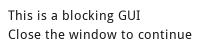

In [17]:
# run() blocks until the window is closed
def simple_gui():
    imgui.text("This is a blocking GUI")
    imgui.text("Close the window to continue")

# This will block until the window is closed
hello_imgui.nb.run(simple_gui, window_title="Blocking GUI", window_size_auto=True)

## Summary

The `hello_imgui.nb` module provides:

- `hello_imgui.nb.start()` - Start GUI non-blocking with notebook-friendly defaults
- `hello_imgui.nb.stop()` - Stop the running GUI
- `hello_imgui.nb.is_running()` - Check if GUI is running
- `hello_imgui.nb.run()` - Blocking mode (delegates to hello_imgui.run)

All functions support the same three signatures:
1. `(RunnerParams)`
2. `(SimpleRunnerParams)`
3. `(gui_function, **kwargs)`

**Differences from immapp.nb:**
- No AddOnsParams support (no ImPlot, ImPlot3D, etc.)
- No automatic light theme or screenshot features
- Simpler API for basic ImGui GUIs